# Using Supermarq with `qiskit-superstaq`

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/demos/supermarq/supermarq_qss.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/demos/supermarq/supermarq_qss.ipynb)

This notebook demonstrates how to use Supermarq, a scalable, hardware-agnostic quantum benchmark suite developed by Infleqtion. Supermarq is built into the Superstaq server, and can be accessed using `qiskit-superstaq`.

In [1]:
try:
    import qiskit
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    import qiskit_superstaq as qss

In [2]:
try:
    import supermarq
except ImportError:
    print("Installing supermarq...")
    %pip install --quiet supermarq
    print("Installed supermarq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import supermarq

In [3]:
# Optional
import os  # Used to store a token in an environment variable

## Basics:

### 1. Provider creation

In [4]:
# Provide your api key to `qss.SuperstaqProvider()` using the `api_key=` argument if
# the SUPERSTAQ_API_KEY environment variable is not set.

# Submit qiskit circuits via `qiskit-superstaq`
provider = qss.SuperstaqProvider()
print(provider.get_balance())

20 credits


In [5]:
# See which targets are available
provider.get_targets(available=True)

[Target(target='aqt_keysight_qpu', supports_submit=False, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(target='aqt_zurich_qpu', supports_submit=False, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(target='aws_dm1_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(target='aws_sv1_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(target='aws_tn1_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(target='cq_sqorpius_qpu', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(target='cq_sqorpius_simulator', supports_submit=True, supports_submit_qubo=False, supports_compile=True, available=True, retired=False),
 Target(targe

### 2. Benchmark instantiation
NOTE: after executing a benchmark circuit, the score should always be evaluated using the same `Benchmark` object that was used to generate the circuit.

All of the benchmarks can be found in `supermarq/benchmarks/`.

Think about other circuits/benchmarks you would like to implement and run!

In [6]:
# Create your benchmark using qiskit circuits
ghz = supermarq.ghz.GHZ(5)
ghz_circuit = ghz.qiskit_circuit()
ghz_circuit.draw()

┌───┐          ┌─┐                      
q_0: ┤ H ├──■───────┤M├──────────────────────
     └───┘┌─┴─┐     └╥┘     ┌─┐              
q_1: ─────┤ X ├──■───╫──────┤M├──────────────
          └───┘┌─┴─┐ ║      └╥┘     ┌─┐      
q_2: ──────────┤ X ├─╫───■───╫──────┤M├──────
               └───┘ ║ ┌─┴─┐ ║      └╥┘┌─┐   
q_3: ────────────────╫─┤ X ├─╫───■───╫─┤M├───
                     ║ └───┘ ║ ┌─┴─┐ ║ └╥┘┌─┐
q_4: ────────────────╫───────╫─┤ X ├─╫──╫─┤M├
                     ║       ║ └───┘ ║  ║ └╥┘
c: 5/════════════════╩═══════╩═══════╩══╩══╩═
                     0       1       2  3  4

### 3. Circuit evaluation
The generated circuits can be evaluated on a backend using any compatible service: AWS Braket, IBM Qiskit, `cirq-superstaq`, `qiskit-superstaq`, etc. Here we use `qiskit-superstaq`

In [7]:
backend = provider.get_backend("ss_unconstrained_simulator")
job_qss = backend.run(ghz_circuit, shots=1000, method="dry-run")

### 4. Compute the score
NOTE: after executing a benchmark circuit, the score should always be evaluated using the same `Benchmark` object that was used to generate the circuit.

In [8]:
job_qss.status()

<JobStatus.DONE: 'job has successfully run'>

In [9]:
counts = job_qss.result().get_counts()
print(counts)
score_qss = ghz.score(counts)
print(score_qss)

{'00000': 508, '11111': 492}
0.9999359959034757


### 5. Visualize the results
The function in `supermarq/plotting.plot_results` produces a simple bar plot. Feel free to copy and paste that code here to generate more detailed figures.

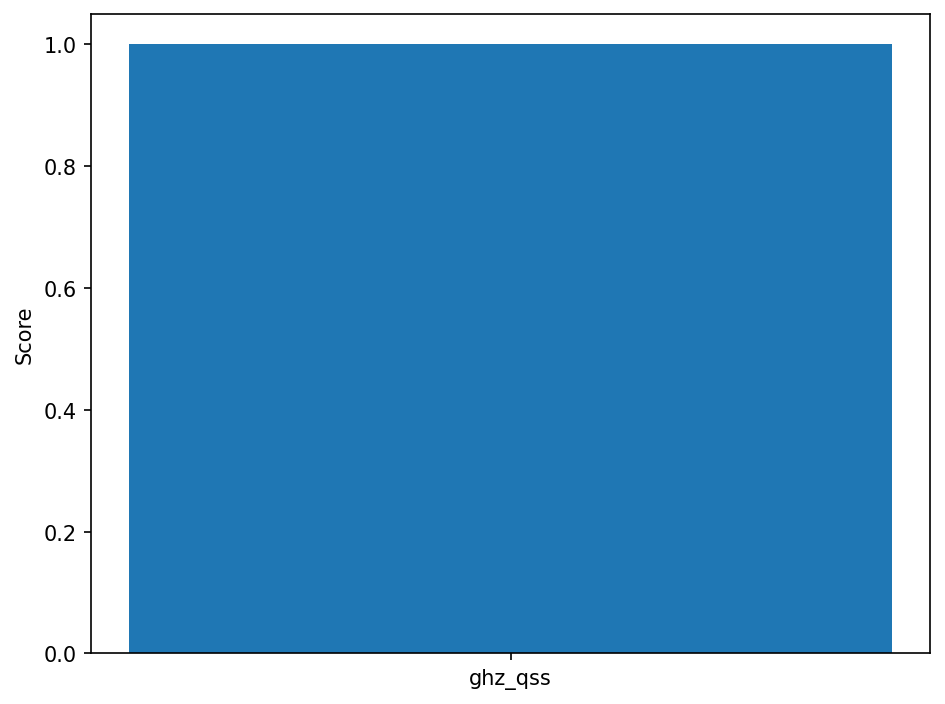

In [10]:
supermarq.plotting.plot_results([score_qss], ["ghz_qss"])

## Quantum Program Profiling
The current hardware-agnostic application features can be found in `supermarq/features.py`. Quantum program profiling is an exciting area of research that is just getting started -- what kinds of features would you find meaningful? Try implementing them!

### Compute features

In [11]:
ghz_circuit = supermarq.ghz.GHZ(10).qiskit_circuit()
ghz_features = [
    supermarq.converters.compute_communication_with_qiskit(ghz_circuit),
    supermarq.converters.compute_depth_with_qiskit(ghz_circuit),
    supermarq.converters.compute_entanglement_with_qiskit(ghz_circuit),
    supermarq.converters.compute_liveness_with_qiskit(ghz_circuit),
    supermarq.converters.compute_measurement_with_qiskit(ghz_circuit),
    supermarq.converters.compute_parallelism_with_qiskit(ghz_circuit),
]
print(ghz_features)

[0.2, 1.0, 0.9, 0.2636363636363636, 0.0, 0.0]


### Visualize the feature vector

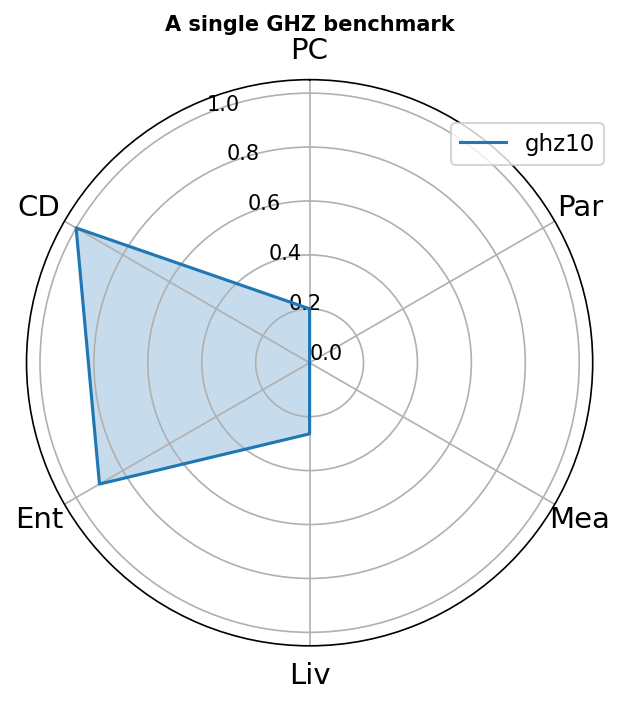

In [12]:
supermarq.plotting.plot_benchmark(
    ["A single GHZ benchmark", ["ghz10"], [ghz_features]],
    spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],
)

## Correlating performance <> features
To correlate the performance of a particular device with a certain application feature, it is helpful to evaluate several different benchmarks on that same device. This code example creates 4 different benchmarks, computes their feature vectors, evaluates them on a backend, and then measures the correlation between the performance seen and the application features.

### Characterize the benchmarks

In [13]:
benchmark_features = {}
benchmarks = [
    (supermarq.ghz.GHZ(5), "ghz5"),
    (supermarq.hamiltonian_simulation.HamiltonianSimulation(4), "hsim4"),
]
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),
    ]
print(benchmark_features)

{'ghz5': [0.4, 1.0, 0.8, 0.4666666666666667, 0.0, 0], 'hsim4': [0.5, 1.0, 0.2857142857142857, 0.5961538461538461, 0.0, 0.38095238095238093]}


### Evaluate

In [14]:
jobs = []
backend = provider.get_backend("ss_unconstrained_simulator")
for benchmark, label in benchmarks:
    job = backend.run(benchmark.qiskit_circuit(), shots=1000)
    jobs.append((label, job, benchmark))

### Wait until the benchmarks have successfully executed...

In [15]:
device_scores = {}

for label, job, benchmark in jobs:
    if job.status() == qiskit.providers.jobstatus.JobStatus.DONE:
        counts = job.result(0).get_counts()
        print(counts)
        score = benchmark.score(counts)
        print(score)
        device_scores[label] = score
    else:
        print(label, "not done!")

{'00000': 493, '11111': 507}
0.9999509975987646
{'0000': 1, '1000': 2, '0100': 1, '1100': 23, '0010': 7, '1010': 13, '0110': 10, '1110': 91, '0001': 3, '1001': 17, '0101': 14, '1101': 88, '0011': 12, '1011': 101, '0111': 81, '1111': 536}
0.9990533905932741


### Measure the correlation between device performance and application features

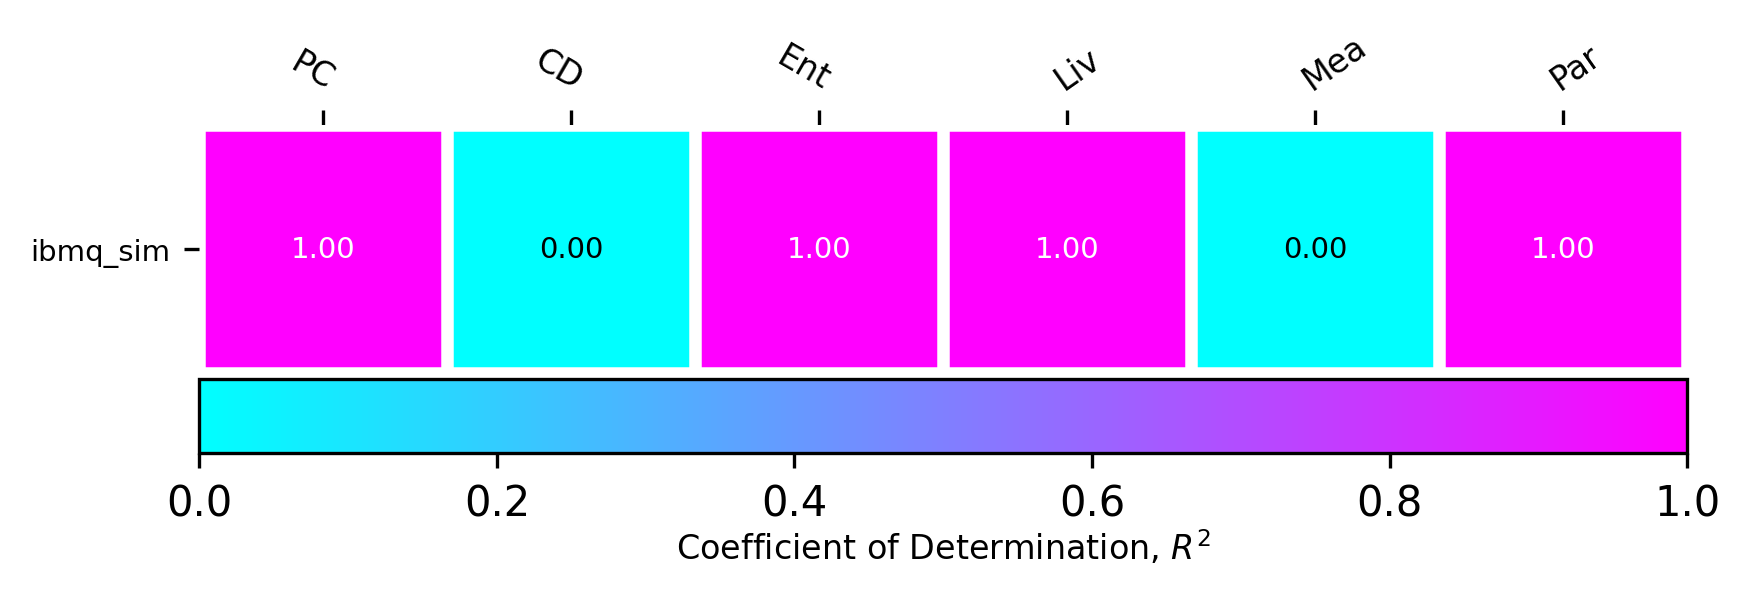

In [16]:
supermarq.plotting.plot_correlations(
    benchmark_features,
    device_scores,
    ["PC", "CD", "Ent", "Liv", "Mea", "Par"],
    device_name="ibmq_sim",
)